# Gibbs measure over a grid tutorial

This notebook illustrates the knockoff construction for a Gibbs measure across a grid with probability mass function
$$p(X) = \frac{1}{Z(\beta_0)} \exp\left(-\beta_0\sum_{\substack{s, t \in \mathcal I \\\|s-t\|_1=1}}(x_s-x_t)^2 \right),\quad\mathcal I = \{(i_1,i_2) : 1\le i_1,i_2 \le d\}.$$
Each variable has support $\{0,\dots,K-1\}$ where $K$ is a positive integer.  Section 5.2.4 of the accompanying paper presents a large set of simulation results in this setting.

## Multiple-try Metropolis

For large $K$, Multiple-try Metropolis (Section 3.3 of the paper) gives the most efficient sampler for this class of distributions. We demonstrate this technique below.

In [1]:
import math
import numpy as np
import time
import seaborn as sns

%run ../Gibbs-grid/Gibbs_MTM #load the Gibbs simulation functions

In [2]:
#simulation parameters
d = 5
p = d * d #total number of variables
K = 5 # support size
beta = 0.2 #interaction strength
numsamples = 100

#algorithm parameters
N_gibbs = 100 #number of iterations for the initial Gibbs sampler
gamma = .99 
half_num_try = 1 #half the number of proposals
step_size = 1 #propsal size
max_width = 2 #slicing width

We use a Gibbs sampler to generate samples from the model, and then generate a corresponding knockoff with the function `SCEP_MH_Gibbs_slice`.

In [3]:
bigmatrix = np.zeros([numsamples,2*p]) #store simulation results

#generate each observation and knockoff
start = time.time()
for i in range(numsamples):
    # sample a single observation
    x_obs = Gibbs_sampler(d, d, K, beta, N = N_gibbs)
    
    #generate a knockoff for the observation
    xk = SCEP_MH_Gibbs_slice(k1 = d, k2 = d, K = K, 
        beta = beta, x_obs = x_obs,  gamma = gamma, 
        half_num_try = half_num_try, step_size = step_size, 
        max_width = max_width)
    bigmatrix[i,:] = np.append(np.reshape(x_obs, p), np.reshape(xk, p))
end = time.time()

print("Average time per observation + knockoff (seconds): " + \
      '%.3f'%((end - start) / numsamples))
    
np.shape(bigmatrix)

Average time per observation + knockoff (seconds): 0.239


(100, 50)

In [4]:
'%.5f'%((start - end) / numsamples)

'-0.23894'

In [5]:
(start - end) / numsamples

-0.23893741130828858

We can evaluate the quality of these knocokffs by computing the average correlation between $X_{i,j}$ and $\tilde{X}_{i,j}$.

In [6]:
cors = []
for j in range(p):
    cors += [np.corrcoef(bigmatrix[:, j].T, 
                         bigmatrix[:, j + p].T)[0,1]]
np.mean(cors)     

0.6848831989416593

#### Diagnostics: checking means and covariances

As a basic diagnostic, we check that each coordinate has mean $(d - 1)/2$ and the the empirical covariance matrices of $X$ and $\tilde{X}$ are close. As the number of samples increases, the empirical covariance of $X$ and $\tilde{X}$ will converge to the same population covariance.

In [7]:
#largest mean of the columns of X
print(np.max(np.abs(np.mean(bigmatrix[:, 0:p], axis = 0))))
#largest mean of the columns of Xk
print(np.max(np.abs(np.mean(bigmatrix[:, p:(2*p)], axis = 0))))

2.23
2.14


In [8]:
#empirical correlation matrices
S = np.corrcoef(bigmatrix[:, 0:p].T)
Sk = np.corrcoef(bigmatrix[:, p:(2*p)].T)

#largest difference in population correlation
np.max(np.abs(S - Sk))

0.3836835715774706

We can visualize the difference in the empirical covariance matrices of $X$ and $\tilde{X}$ with a heatmap.

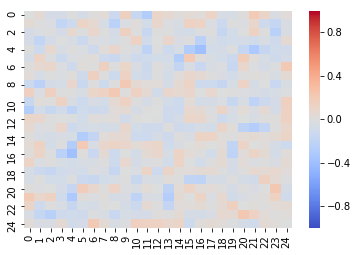

In [9]:
S = np.corrcoef(bigmatrix[:, 0:p].T)
Sk = np.corrcoef(bigmatrix[:, p:(2*p)].T)
ax = sns.heatmap(S - Sk, vmin = -1, vmax = 1, cmap="coolwarm")

We see that the difference in the empirical correlation matrix of $X$ and the empirical correlation matrix of $\tilde{X}$ are small, as expected, since $X$ and $\tilde{X}$ come from the same distribution.